# CCUR FS 2024 - Toy Model Exercise 1

Exercise instruction PDF: add link here

Group 9: Noah, Yitao, Fabienne 

In [1]:
## Load packages
import os
import pickle
import datetime
import numpy as np
import pandas as pd

from scipy import stats
from statsmodels.tsa.stattools import acf, pacf

import pylab
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# further imported packages
from scipy.optimize import curve_fit
from scipy.stats import t
from scipy.stats import norm
from numpy.random import normal
from numpy.random import lognormal
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter

DPI = 250

## Some plotting defaults
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'mathtext.default':'regular'}) 

In [2]:
## Some plotting defaults
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'regular'}) 

In [3]:
## Folder needs to be adapted to where you saved it
dir_in_data  = 'data/'                    

## Load the data
si_short = pd.read_pickle(os.path.join(dir_in_data,'FS2024_SI_obs.pkl'))

In [4]:
## conversion of the data into numpy array format

a_si_short = np.array(si_short)
N = len(a_si_short)
months = np.arange(0,N,1)
years = 1998 + months/12

## 1. Statistical modeling of past observations
### Deterministic part – the trend

1.a) What are the corresponding regression coefficients  and  (where the intercept should be estimated for the first time step January 1998)?

In [5]:
## linear fit method 1 unsing scipy.stats.linregress

res_linreg = stats.linregress(months,a_si_short)
beta1, beta0 = res_linreg[:2]

    # print results
print('beta0_:',np.round(beta0,6),'m/s')
print('beta1_:',np.round(beta1,6),'m/(s*month)')

     # linear regression model
lin_reg = lambda x, beta_0, beta_1 : beta_0 + x * beta_1

"""
## linear fit method 2 using scipy.optimize

    # initial values (estimated using the first and the last value from a_si_short)
beta0_i = a_si_short[0] ; beta1_i = (a_si_short[-1] - a_si_short[0]) / 200
p_0 = (beta0_i,beta1_i)

    # perform the fit using scipy.optimize.curve_fit
fit_1 = curve_fit(lin_reg,months,a_si_short,p_0)

    # store fit values and corresponding errors
beta0, beta1 = fit_1[0]
e_beta0, e_beta1 = np.sqrt(np.diag(fit_1[1]))

    # print results
print('beta0:',np.round(beta0,2),'+-',np.round(e_beta0,2),'m/s')
print('beta1:',np.round(beta1,4),'+-',np.round(e_beta1,4),'m/(s*month)')
""";

    # evauate the fitted linear model 
lin_reg_si = lin_reg(months,beta0,beta1)

    # de-trend data
residuals_si = a_si_short - lin_reg_si


beta0_: 13.778929 m/s
beta1_: 0.006938 m/(s*month)


__1.b) What other (more robust) method could be applied to estimate the trend?__

The linear least square method reacts sensitively to statistical outliers in the data, thus significance level and with that reliability of the trend estimation from linear least square method is not robust. More robust methods are (1) the least median square method, where the sum of the squared residuals is replaced by their median, as well as (2) an adapted least square method, where only the first, say $h < n$ smallest squared residuals (from in total $n$ datapoints) are taken into account, and all $n-h$ larger squared residuals are neglected. Both methods aim at mitigating the impact of extreme values, either by (1) reducing their influence or (2) taking it out of the regression calibration overall. 

$\begin{align*}
(1)\hspace{0.5cm}&\min_{\beta_i} \underset{j=0,...,n}{\text{med}} r_j^2 \\
(2)\hspace{0.5cm}&\min_{\beta_i} \sum_{j=1}^h r_j^2, \hspace{0.5cm}\text{ for }r_1^2 < r_2^2 < ... < r_n^2 \text{ and }h<n
\end{align*}$

__1.c) Assuming the linear regression model to be valid, is the trend significant on a 5 % level?__

The p-value is calculated using a cummulative t-distribution:

- t-distribution: $\mathsf{f}(x,n) = \frac{\Gamma((n+1)/2)}{\sqrt{\pi n} \cdot \Gamma (n/2)} (1+ x^2/n)^{-(n+1)/2} $ , where $n = N-2$ is the number of degrees of freedom, $N$ is the number of data-points and $\Gamma$ is the gamma-function.

- Complementary cummulative t-distribution: $\mathsf{ccf}(t,n) = \int_t^\infty \mathrm{d}x \hspace{0.1cm} \mathsf{f}(x,n)$.
- t-value: $t = \beta_1 / \sigma_{\beta_1}$, where $(\beta_1,\sigma_{\beta_1}) = ($```beta1```,```e_beta1```$)$ where obtained from the fit.
- p-value: $p = 2\times \mathsf{ccf}(t,n)$
- Significance level: $\alpha \equiv 0.05$

Now the trends is said to be significant, if $p < \alpha$.

In [6]:
## p-value obtained from linear fit method 1
print(r'The p-value is %.3e < 0.05' %res_linreg[3])

"""
## p-value obtained from linear fit method 2

n = N - 2
tval = beta1/e_beta1
pval = 2 * t.sf(tval,n)
print(r'The p-value is %.3e < 0.05' %pval)
""";


The p-value is 1.605e-17 < 0.05


So the trend is significant, since $p < 0.05$

__1.d)	What are the assumptions on the residuals for the linear regression and are they fulfilled? Discuss each assumption with a plot and 1-2 sentences using the detrended data. You can use the functions ```plt.hist()```, ```stats.probplot()``` and ```acf()```/```pacf()```, and plot the residuals against the fitted values (Tukey Anscombe plot).__

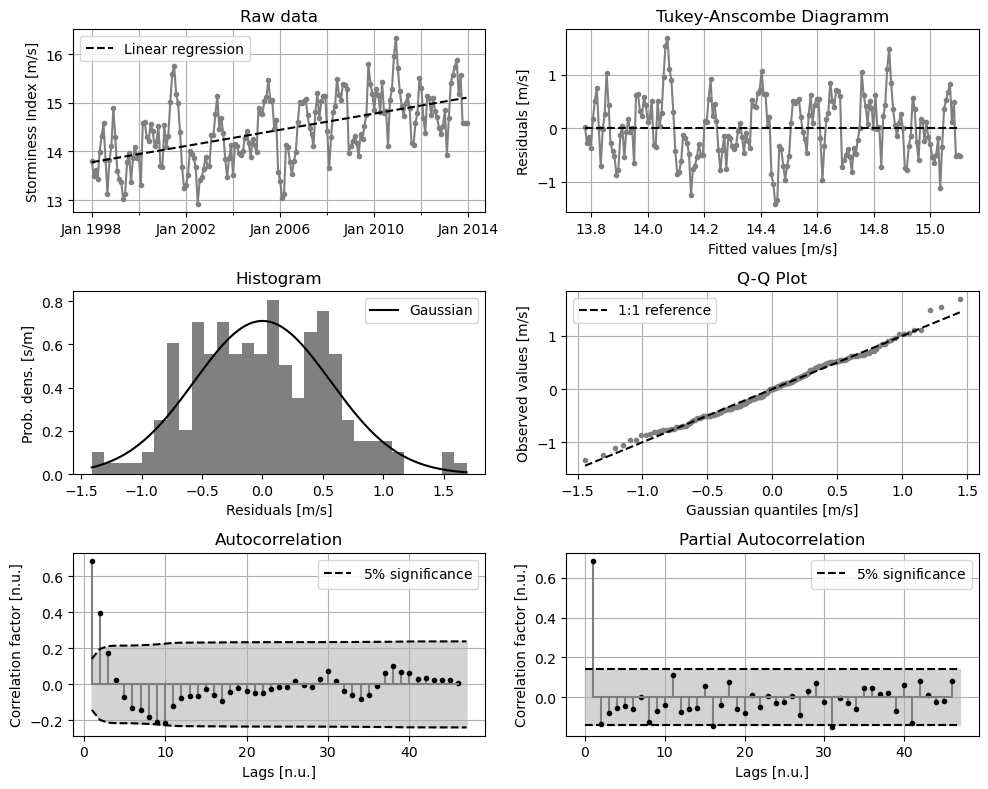

In [7]:
## methods for calculating Tukey Ansombe diagram, histogram, Q-Q Plot, autocorrelation and partial autocorrelation

def cov(a,b):
    """
    calculates mean and std of a, b and the correlation coefficient of a and b
    """
    
    N = len(a)
    if N != len(b):
        print("a and b must have same dimension")
    else:
            # calculate mean values of a, b
        m_a = np.sum(a)/N ; m_b = np.sum(b)/N
        
            # calculate variance and standard deviations of a, b
        var_a = np.sum((m_a-a)**2)/N ; var_b = np.sum((m_b-b)**2)/N
        std_a = np.sqrt(var_a) ; std_b = np.sqrt(var_b)
        
            # calculate covariance of a, b
        cov_ab = np.sum((m_a-a)*(m_b-b))/N

            # calculate correlation coefficient of a and b
        rho_ab =  cov_ab/(std_a*std_b)

            # returns
        return rho_ab, cov_ab , np.array([m_a,std_a]), np.array([m_b,std_b])


def hist(a,n_bins,axis):
    """
    calculates the histogram of a for n_bins number of bins and plots the histogram with corresponding gaussian
    """
    
    N = len(a)
    
        # calculate gaussian distribution
    a_m = np.mean(a) ; a_std = np.std(a)
    a_linspace = np.linspace(min(a),max(a),10*N)
    gaussian_a = norm.pdf(a_linspace ,loc=a_m, scale=a_std)

        # plot histogram and gaussian and store histogram values
    #fig,ax = plt.subplots(1,1,figsize=(10,8))
    axis.plot(a_linspace, gaussian_a,'-',color='black',label=r'Gaussian')
    a_hist = axis.hist(a,n_bins,density=True,color='gray')
    axis.set_title('Histogram')
    axis.set_xlabel('Residuals [m/s]')
    axis.set_ylabel('Prob. dens. [s/m]')
    axis.legend()

            # Another possibility to asses is to split the residuals into quantiles and compare their histograms, or calculate their means and std's. 
            # hist_left = ax.hist(residuals_si[:int(0.3*N)],10,color='gray')
            # hist_right = ax.hist(residuals_si[int(0.7*N):],10,color='blue')

        # returns
    return a_hist


def aut_corr(a,axis):
    """
    computes the auto-correlation of a for index-steps Delta from 1 to len(a)-1
    if required (plot==True), plots the auto-correlation against the index-steps
    """

    """
    hand-written code for computing the autocorrelation
    """
    N = len(a)

       # array for the index-steps 
    Delta = np.arange(1,int(N/4),1)

        # list to store the computed auto-correlation values for different Delta's
    R_aa = []

        # compute mean and variance of a
    m_a = np.sum(a)/N
    var_a = np.sum((m_a-a)**2)/N

        # iterate through Delta
    for d in Delta:

        n = N - d
        
            # compute corresponding auto-correlation
        r_aa = np.sum((a[:-d]-m_a)*(a[d:]-m_a))/(n*var_a)
        
            # normalize and store the computed value
        R_aa.append(r_aa)

    """
    Code for calculating acf using the method provided by statsmodel. 
    Results are identical to the ones I obtained with my code :) - but they are calculated more efficiently
    """
    
        # calculate autocorrelationfunction using fft (adjusted: divide by n instead N)
    R_aa_stats,conf  = acf(a,adjusted=True,nlags=len(Delta),alpha=.05)
    conf[:,0] = conf[:,0]-R_aa_stats
    conf[:,1] = conf[:,1]-R_aa_stats
    Delta_stats = np.arange(len(R_aa_stats))
    
        # plot the auto-correlation against the index-steps
    axis.stem(Delta_stats[1:-1],R_aa_stats[1:-1], linefmt='0.5', markerfmt='k.', basefmt='0.5')
    axis.fill_between(Delta_stats[1:],conf[1:,0],conf[1:,1],color='lightgray')
    axis.plot(Delta_stats[1:],conf[1:,1],'--',color='black',label=r'$5\%$ significance')
    axis.plot(Delta_stats[1:],conf[1:,0],'--',color='black')
    axis.set_title(r'Autocorrelation')
    axis.set_xlabel(r'Lags [n.u.]')
    axis.set_ylabel(r'Correlation factor [n.u.]')
    axis.grid()
    axis.legend()

        # retrun result as an array
    return R_aa

def part_aut_corr(a,axis):
    """
    Calculates the partial autocorrelation using statsmodel 
    Implementation by hand is far too complicated as far as I see :,( 
    """
    N = len(a)

        # number of lags and array for the plot
    n_lags = int(N/4)-1
    Delta_stats = np.arange(n_lags+1)

        # calculate the partial autocorrelation
        # and the confidence interval for 95% significance (2 sigma; 1.96 = sqrt(2)*erf^-1(0.95) )
    PHI_aa_stats,conf = pacf(a, nlags=n_lags,alpha=0.05)
    conf[:,0] = conf[:,0]-PHI_aa_stats
    conf[:,1] = conf[:,1]-PHI_aa_stats

    # plot the auto-correlation against the index-steps

        # artefacte for plotting
    conf[0,0] = conf[1,0] ; conf[0,1] = conf[1,1]

        # plot pacf as stem plot
    axis.stem(Delta_stats[1:-1],PHI_aa_stats[1:-1], linefmt='0.5', markerfmt='k.', basefmt='0.5')

        # plot error interval
    axis.plot(Delta_stats,conf[:,1],'--', color = 'black',label=r'$5\%$ significance')
    axis.plot(Delta_stats,conf[:,0],'--', color = 'black')
    axis.fill_between(Delta_stats,conf[:,1],conf[:,0],color='lightgray')

        # set layout and axes
    axis.set_title(r'Partial Autocorrelation')
    axis.set_xlabel(r'Lags [n.u.]')
    axis.set_ylabel(r'Correlation factor [n.u.]')
    axis.grid()
    axis.legend()

        # returns
    return PHI_aa_stats

def QQ_plot(a,axis):
    """
    Computes the Q-Q-plot for given dataset a for Gaussian distribution
    returns the normal value and the reordered values of a in corresponding order, ready to plot ;)
    autamtic plot if required (plot==True)
    """
    n = len(a)
    a_m = np.mean(a); a_std = np.std(a)

        # rearrange a
    sort_index = np.argsort(a)
    a_sort = a[sort_index]

        # calculate corresponding "gauss-distribution values"
        # norm.isf() is the inverse cummulative Gaussian
    a_gauss = np.array([norm.isf((n-i)/n, loc = a_m, scale = a_std) for i in range(n)])

    axis.set_title('Q-Q Plot')
    axis.plot(a_gauss,a_sort,".",color='gray')
    axis.plot(a_gauss,a_gauss,"--",color='black',label='1:1 reference')
    axis.set_xlabel(r'Gaussian quantiles [m/s]') 
    axis.set_ylabel(r'Observed values [m/s]')
    axis.legend(fontsize='10')
    axis.grid()
    
        # returns 
    return a_gauss, a_sort

## Compute and plot the results

fig, ax = plt.subplots(3,2,figsize=(10,8),gridspec_kw={'height_ratios': [1, 1, 1]})

xticks = np.arange(1998, 2015, 4)
xlabels = [f'Jan {x:1.2f}' for x in xticks]
ax[0,0].set_xticks(xticks)#, labels=xlabels)
ax[0,0].xaxis.set_major_formatter(ticker.FormatStrFormatter('Jan %g'))
ax[0,0].xaxis.set_minor_locator(ticker.MultipleLocator(base=12))
ax[0,0].xaxis.set_minor_locator(ticker.MultipleLocator(base=2))

ax[0,0].set_title('Raw data')
ax[0,0].plot(years,a_si_short,'.-',color='gray')
ax[0,0].plot(years,lin_reg_si,'--',label='Linear regression',color='black')
ax[0,0].set_ylabel(r'Storminess Index [m/s]')
ax[0,0].grid(which='both')
ax[0,0].legend()

ax[0,1].set_title('Tukey-Anscombe Diagramm')
ax[0,1].plot(lin_reg_si,residuals_si,'.-',color='gray')
ax[0,1].plot(lin_reg_si,np.zeros(len(lin_reg_si)),'--',color='black')
ax[0,1].set_xlabel('Fitted values [m/s]')
ax[0,1].set_ylabel('Residuals [m/s]')
ax[0,1].grid()

a_si_hist = hist(residuals_si,30,ax[1,0])

a_si_QQ = QQ_plot(residuals_si,ax[1,1])

aut_corr_si = aut_corr(residuals_si,ax[2,0])

part_aut_corr_si = part_aut_corr(residuals_si,ax[2,1])

    # prevent ugly overlaps of axis labels and titles
plt.tight_layout()

    # save figure
plt.savefig("error_analysis_historical data")


Mathematically, the linear least square method for trend estimation is based on the assumptions, that (1) the measurements are _independent_ from each other, i.e. the data does not or does almost not exhibit autocorrelation. Besides this (2) the residuals must be _normally_ distributed and eventually (3) the variance of the residuals must be constant over the whole series of measurements, which is referred to as _homoscedasticity_.

* Looking at the __ACF and PACF plot__, we can conclude that the signal is not strongly autocorrelated (high correlation factors for smalls lags are due to assumed temporal continuity of the measured quantity), so there is evidence, that the residuals are _independent_. Furthermore from the _PACF_ in particular one can see that it is reasonable to assume that the order of the autoregressive process is 1, since the only significant peak is at lag 1.
* Looking at the __histogram__ and __QQ-plot__, we can conclude that the histogram at least graphically fits the corresponding Gaussian distribution and that in the Q-Q-Plot the deviation of the observed values from the Gaussian quantiles are small. Hence there is evidence that the residuals are _normally_ distributed.
* Looking at the __Tukey-Ascombe plot__, we can conclude that there is no significant widening nor narrowing of the de-trended data over time, meaning that the variance/spreading of the residuals is independant of time. Hence there is (graphical) evidence that the residuals are _homoscedastic_. 


__1.e) Can you come up with physical explanations for the outcome of 1.d)? Write maximal two sentences.__

(First of all, significant linear regressions do not allow to infer an underlying phyical linear law. Besides this linear least square method for fitting is biased particularly in terms of significance levels due to the autocorrelation and therefore it is rather difficult to argue quantitatively for or against the physical validity of such a fit.) 

The fact that the residuals are distributed normally can be understood as a consequence of the the central limit theorem. The significant autocorrelation for lag 1 and 2 do reflect continuity of the observed physical quantity; the lag width is identical with the temporal resolution, namely 1 month, and it seems reasonable that weather patterns, i.e. periods of comparable SI, last a few weeks up to a few months. 

__1.f) What is the order (p) of the auto-regressive process leading to the partial autocorrelation observed in the residuals? Have a look at the plot you created in 1.d) using ```acf()```/```pacf()```. What is the partial auto-correlation α at lag 1?__


In [8]:
alpha = part_aut_corr_si[1]

print('The lag-1 (partial)autocorrelation is %.3f.' %alpha)

The lag-1 (partial)autocorrelation is 0.685.


The lag-1 partial-autocorrelation (per definition equal to the lag-1 autocorrelation) is $\alpha = 0.658$.

__1.g) How does the autocorrelation affect the trend estimate $\beta_1$ (see 1.a) and the variance thereof? What does this imply for the significance of the trend you have estimated in 1.c)?__

A prior autocorrelation of the residuals does not have an influence on the estimated trend itself – for example a linear function with sinusoidal modulation, $f(x) = \beta_0 + \beta_1 x + sin(x)$ exhibits strongly autocorrelated residuals but linear regression  will definitely yield the correct trend $\beta_1$ However, a higher autocorrelation means that the variance and the uncertainty of the trend estimation $\sigma_{\beta_1}$ are under-estimated and therefore standard statistical tests that assume independence of observations can give misleading results. Because of this, the t-value $\beta_1/\sigma_{\beta_1}$ will decrease accordingly. As a consequence, the significance of the estimated trend gets reduced in the sense that there is a higher probability that $t<p$.

__1.h) What is the standard deviation (σ) of $w_t$ assuming a normal distribution? Remember that $w_t = \epsilon_t - \epsilon_{t-1} \cdot \alpha$ according to equation (2).__

In [9]:
w_si = residuals_si[1:]-residuals_si[:-1]*alpha
sigma_w = np.std(w_si)

print('The standard deviation of w_t is: %.3f m/s' %sigma_w)

sigma = sigma_w

The standard deviation of w_t is: 0.412 m/s


### Reproduce observations – Trend + AR(1)

__1.i) Generate one realisation of your model and compare it (visually) with the observations.__

We know the model parameter $(\beta_0,\beta_1,\alpha,\sigma)$, and the following relations:

(1) $x_t = \beta_0 + \beta_1 \cdot t + \varepsilon_t$ 

(2) $\varepsilon_t = \alpha\cdot \varepsilon_{t-1} + w_t$ 

(3) $w_t = N(0,\sigma^2)$

Together with an initial value $x_{t=0}$ we find the following recursion formula:

(4) $x_t = \alpha  x_{t-1} + (1-\alpha) (\beta_0 + \beta_1 t) + \alpha  \beta_1 + w_t$

In [10]:

# define model (eq. (4))
def eq4(x_i,N,Beta0=beta0,Beta1=beta1,Alpha=alpha,Sigma=sigma): 
    """
    evaluates model (eq. (4)) for N timesteps and initial value x_i and the parameters obtained from above
    """
    a = np.zeros(N)
    a[0] = x_i
    for t in range(1,N):
        a[t] = Alpha*a[t-1]+(1-Alpha)*(Beta0+Beta1*t)+Alpha*Beta1+normal(loc=0,scale=Sigma)
    return a

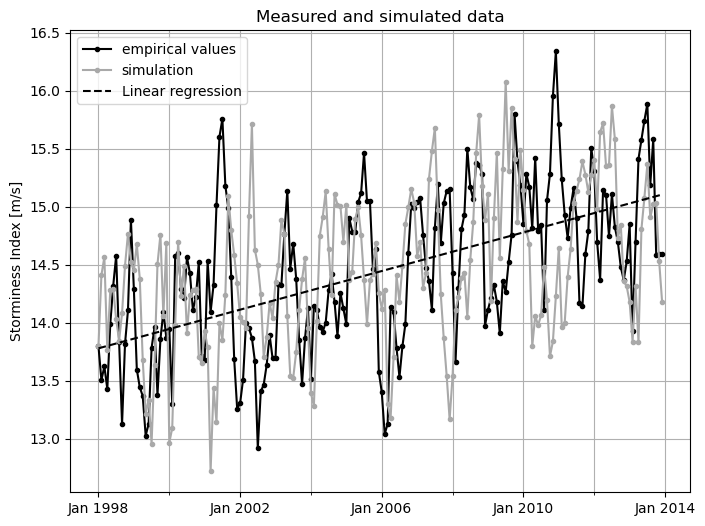

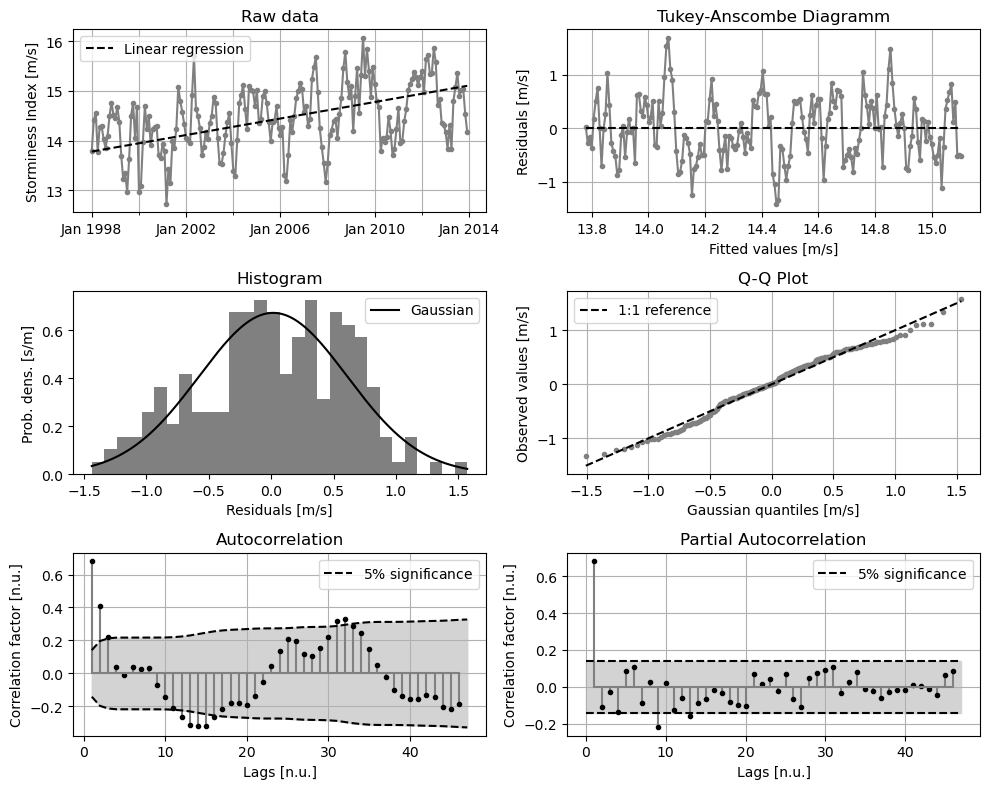

In [11]:
    # set length of the two realisations of the model
N_1 = len(a_si_short)

    # set initial value
x0 = a_si_short[0]

    # evaluating the model
a_x_1 = eq4(x0,N_1)

    # Plotting routine
fig, ax = plt.subplots(1,1,figsize=(8,6))
xticks = np.arange(1998, 2015, 4)
xlabels = [f'Jan {x:1.2f}' for x in xticks]
ax.set_xticks(xticks)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('Jan %g'))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=12))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=2))

ax.set_title('Measured and simulated data')
ax.plot(years,a_si_short,'.-',color='black',label='empirical values')
ax.plot(years,a_x_1,'.-',color='darkgray',label='simulation')
ax.plot(years,lin_reg_si,'--',label='Linear regression',color='black')
ax.set_ylabel(r'Storminess Index [m/s]')
ax.grid(which='both')
ax.legend()

residuals_1 = a_x_1 - lin_reg_si

fig, ax = plt.subplots(3,2,figsize=(10,8),gridspec_kw={'height_ratios': [1, 1, 1]})

xticks = np.arange(1998, 2015, 4)
xlabels = [f'Jan {x:1.2f}' for x in xticks]
ax[0,0].set_xticks(xticks)#, labels=xlabels)
ax[0,0].xaxis.set_major_formatter(ticker.FormatStrFormatter('Jan %g'))
ax[0,0].xaxis.set_minor_locator(ticker.MultipleLocator(base=12))
ax[0,0].xaxis.set_minor_locator(ticker.MultipleLocator(base=2))

ax[0,0].set_title('Raw data')
ax[0,0].plot(years,a_x_1,'.-',color='gray')
ax[0,0].plot(years,lin_reg_si,'--',label='Linear regression',color='black')
ax[0,0].set_ylabel(r'Storminess Index [m/s]')
ax[0,0].grid(which='both')
ax[0,0].legend()

ax[0,1].set_title('Tukey-Anscombe Diagramm')
ax[0,1].plot(lin_reg_si,residuals_si,'.-',color='gray')
ax[0,1].plot(lin_reg_si,np.zeros(len(lin_reg_si)),'--',color='black')
ax[0,1].set_xlabel('Fitted values [m/s]')
ax[0,1].set_ylabel('Residuals [m/s]')
ax[0,1].grid()

a_x_hist_1 = hist(residuals_1,30,ax[1,0])

a_x_QQ_1 = QQ_plot(residuals_1,ax[1,1])

aut_corr_x_1 = aut_corr(residuals_1,ax[2,0])

part_aut_corr_x_1 = part_aut_corr(residuals_1,ax[2,1])

    # prevent ugly overlaps of axis labels and titles
plt.tight_layout()

The model reproduces the data adequately in a qualitative sense: as expected, the linear trend is reproduced and the slight auto-correlation of the residuals as well. The fact that histogram, Q-Q plot and (partial) autocorrelation of the simulated data look similar to the corresponding plots for real data is a direct consequence of the model, which was inferred from the interpretation of these plots for the real data. 

## 2.	Probabilistic realisations of the historical and a future time period

__2.a)	In a first step, in order to assure that the model is in accordance with the observational data, conduct a Monte-Carlo simulation with 10'000 realisations for the observational period (Jan 1998 to Dec 2013). Plot these realisations together with the historical time series in one figure. Would you consider the observed time series a potential realisation of your stochastic model?__

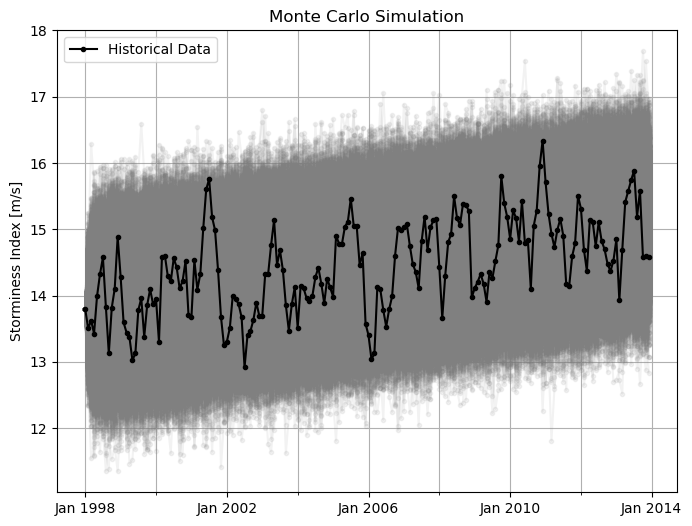

In [12]:
# Define model from exercise 1i): 
def eq4(x_i,N,Beta0=beta0,Beta1=beta1,Alpha=alpha,Sigma=sigma): 
    """
    evaluates model (eq. (4)) for N timesteps and initial value x_i and the parameters obtained from above
    """
    a = np.zeros(N)
    a[0] = x_i
    for t in range(1,N):
        a[t] = Alpha*a[t-1]+(1-Alpha)*(Beta0+Beta1*t)+Alpha*Beta1+normal(loc=0,scale=Sigma)
    return a
    
# Define parameters: 
N = len(a_si_short) # Length observational period (Jan 1998 to Dec 2013)
x0 = a_si_short[0] # Initial value for the simulations
num_of_simulations = 10000 # Number of Monte Carlo simulations

mc_results = np.zeros((num_of_simulations, N)) # Initialize array to store results

for i in range(num_of_simulations):   # Perform Monte Carlo simulations
    mc_results[i] = eq4(x0, N)


## PLOT
# Plot the simulated data:
fig, ax = plt.subplots(figsize=(8, 6))

xticks = np.arange(1998, 2015, 4)
xlabels = [f'Jan {x:1.2f}' for x in xticks]
ax.set_xticks(xticks)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('Jan %g'))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=12))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=2))

ax.set_title('Monte Carlo Simulation')
ax.set_ylabel(r'Storminess Index [m/s]')
ax.grid(which='both')

for i in range(num_of_simulations): # Plot each monte carlo realisation
    ax.plot(years, mc_results[i], '.-', color='gray', alpha=0.1)  

ax.plot(years, a_si_short, '.-', color='black', alpha=1, label='Historical Data') # Plot historical data

ax.legend()
plt.show()


Since the stochastic model fits the observed data pretty well, we could consider the time series as a potential realisation of the model. 

__2.b)	In a second step, generate another 10’000 realisations for future time steps (Jan 2014 to Feb 2027), based on the extrapolated trend you estimated in part 1 of this exercise. Exploit the information of the last observations in order to reduce uncertainty in your forecast by initialising the AR(1) process at the last observational value. Add the respective simulations to the plot of 2.a).__

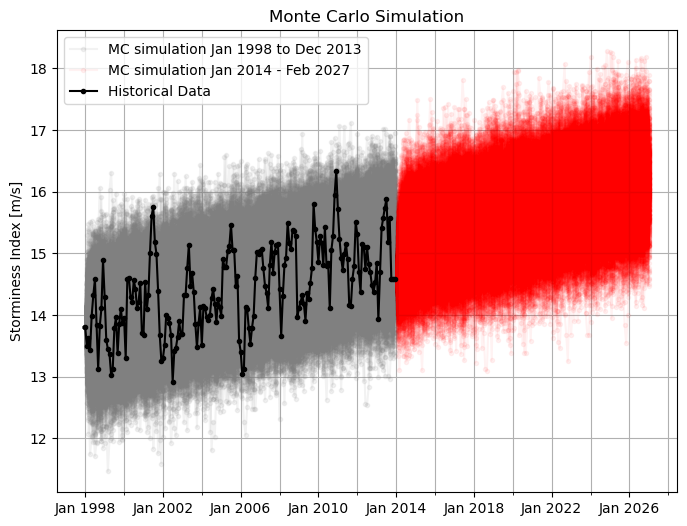

In [28]:
# Our model  

N_0 = len(a_si_short)

def eq4_future(x_i,N,Beta0=beta0,Beta1=beta1,Alpha=alpha,Sigma=sigma): 
    """
    evaluates model (eq. (4)) for N timesteps and initial value x_i and the parameters obtained from above
    """
    a = np.zeros(N)
    a[0] = x_i
    for t in range(1,N):
        a[t] = Alpha*a[t-1]+(1-Alpha)*(Beta0+Beta1*(t+N_0))+Alpha*Beta1+normal(loc=0,scale=Sigma)
    return a

##Historical period Monte Carlo Simulation
# Define parameters for historical period: 
N = len(a_si_short) # Length observational period (Jan 1998 to Dec 2013)
x0 = a_si_short[0] # Initial value for the simulations
num_of_simulations = 1000 # Number of Monte Carlo simulations

mc_results = np.zeros((num_of_simulations, N)) # Initialize array to store results

for i in range(num_of_simulations):   # Monte Carlo simulations Jan 1998 - Dec 2013
    mc_results[i] = eq4(x0, N)

##Future period Monte Carlo Simulation
# Define parameters for future period
future_years = np.arange(2014, 2027 + 1/12, 1/12)  # Array from Jan 2014 to Feb 2027
future_N = len(future_years)  # Length of future period
x0_future = a_si_short[-1] #inital value future period (last observational value) 

future_results = np.zeros((num_of_simulations, future_N)) # Initialize array to store results for future realizations

for i in range(num_of_simulations):                #Monte Carlo simulation for Jan 2014 - Feb 2027
    future_results[i] = eq4_future(x0_future,future_N)

# PLOT
fig, ax = plt.subplots(figsize=(8, 6))

xticks = np.arange(1998, 2028, 4)
xlabels = [f'Jan {x:1.2f}' for x in xticks]
ax.set_xticks(xticks)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('Jan %g'))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=12))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=2))

ax.set_title('Monte Carlo Simulation')
ax.set_ylabel(r'Storminess Index [m/s]')
ax.grid(which='both')

# Plot each Monte Carlo realization for historical data
ax.plot(years, mc_results[0], '.-', color='gray', alpha=0.1,label='MC simulation Jan 1998 to Dec 2013')
for i in range(1,num_of_simulations):
    ax.plot(years, mc_results[i], '.-', color='gray', alpha=0.1)

# Plot each Monte Carlo realization for future data
ax.plot(future_years, future_results[0], '.-', color='red', alpha=0.05, label='MC simulation Jan 2014 - Feb 2027') 
for i in range(1,num_of_simulations):
    ax.plot(future_years, future_results[i], '.-', color='red', alpha=0.05)  

# Plot historical data
ax.plot(years, a_si_short, '.-', color='black', alpha=1, label='Historical Data')

leg = ax.legend()

plt.show()

__2.c)	Plot the median of all (past and future) realisations for each month. With the function ```plt.fill_between()``` you can plot area between (1) the interquartile range and (2) the 2.5 and 97.5 percentile and (3) the minimum and maximum value per month. Use different transparency for the different ranges controlled by the function argument alpha. Further add the estimated trend line (dotted linestyle) and check whether the simulated values agree with your model. How well do the statistical characteristics of your simulations compare with observed time series?__

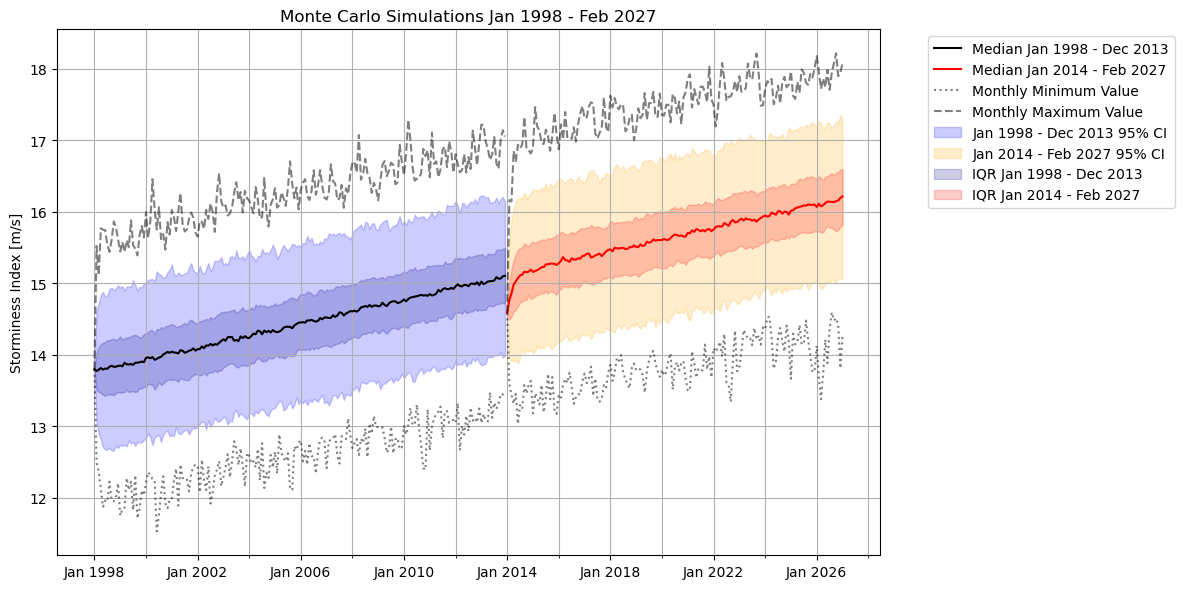

In [14]:
# Calculate median for Jan 1998 - Dec 2013
historical_median = np.median(mc_results, axis=0)
# Calculate median for Jan 2014 - Feb 2017
future_median = np.median(future_results, axis=0)

# Calculate the interquartile range (IQR) for Jan 1998 - Dec 2013
historical_lower = np.percentile(mc_results, 25, axis=0)
historical_upper = np.percentile(mc_results, 75, axis=0)

# Calculate the interquartile range (IQR) for Jan 2014 - Feb 2027
future_lower = np.percentile(future_results, 25, axis=0)
future_upper = np.percentile(future_results, 75, axis=0)

# Calculate percentiles for for Jan 1998 - Dec 2013
historical_percentiles = np.percentile(mc_results, [2.5, 97.5], axis=0)
historical_lower_2_5 = historical_percentiles[0]
historical_upper_97_5 = historical_percentiles[1]

# Calculate percentiles for Jan 2014 - Feb 2027
future_percentiles = np.percentile(future_results, [2.5, 97.5], axis=0)
future_lower_2_5 = future_percentiles[0]
future_upper_97_5 = future_percentiles[1]

# Calculate minimum and maximum values per month for Jan 1998 - Dec 2013
historical_min_per_month = np.min(mc_results, axis=0)
historical_max_per_month = np.max(mc_results, axis=0)

# Calculate minimum and maximum values per month for Jan 2014 - Feb 2027
future_min_per_month = np.min(future_results, axis=0)
future_max_per_month = np.max(future_results, axis=0)

# PLOT
fig, ax = plt.subplots(figsize=(12, 6))

# Set x-axis ticks and labels
xticks = np.arange(1998, 2028, 4)
xlabels = [f'Jan {x:1.2f}' for x in xticks]
ax.set_xticks(xticks)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('Jan %g'))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=12))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=2))

# Set plot title and labels
ax.set_title('Monte Carlo Simulations Jan 1998 - Feb 2027')
ax.set_ylabel(r'Storminess Index [m/s]')
ax.grid(which='both')

# Plot median
ax.plot(years, historical_median, '-', color='black', label='Median Jan 1998 - Dec 2013') 
ax.plot(future_years, future_median, '-', color='red', label='Median Jan 2014 - Feb 2027')

# Plot percentiles
ax.fill_between(years, historical_lower_2_5, historical_upper_97_5, color='blue', alpha=0.2, label='Jan 1998 - Dec 2013 95% CI')
ax.fill_between(future_years, future_lower_2_5, future_upper_97_5, color='orange', alpha=0.2, label='Jan 2014 - Feb 2027 95% CI')

# Plot the area between the interquartile range
ax.fill_between(years, historical_lower, historical_upper, color='darkblue', alpha=0.2, label='IQR Jan 1998 - Dec 2013')
ax.fill_between(future_years, future_lower, future_upper, color='red', alpha=0.2, label='IQR Jan 2014 - Feb 2027')

# Plot minimum and maximum values per month for historical data
ax.plot(years, historical_min_per_month, ':', color='black', alpha=0.5, label='Monthly Minimum Value')
ax.plot(years, historical_max_per_month, '--', color='black', alpha=0.5, label='Monthly Maximum Value')

# Plot minimum and maximum values per month for future data
ax.plot(future_years, future_min_per_month, ':', color='black', alpha=0.5)
ax.plot(future_years, future_max_per_month, '--', color='black', alpha=0.5)


ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax.grid(True)

plt.tight_layout()  # Adjust layout to prevent clipping of legend
plt.show()


From the graph, it can be seen that the historical data in black fits quite comfortably in the interquartile range of our simulations, which supports the fact that the statistical characteristics of our simulations are adapted to the observed time series.

## 3. Forecast and ”Reality” – a little excursus

__3.a)	Load the extended observational dataset, observations ```FS2024_SI_obs_long.pkl``` into your notebook. Take the plot of your probabilistic realisations of exercise 2.c) and add the observations from Jan 2014 to Feb 2024 to the same figure.__

In [16]:
## Load the data
si_long = pd.read_pickle(os.path.join(dir_in_data,'FS2024_SI_obs_long.pkl'))

    # again converrt si_long into numpy array for better handling
a_si_long = np.array(si_long)
N_total = len(a_si_long)
total_years = np.arange(1998, 2027 + 1/12, 1/12)

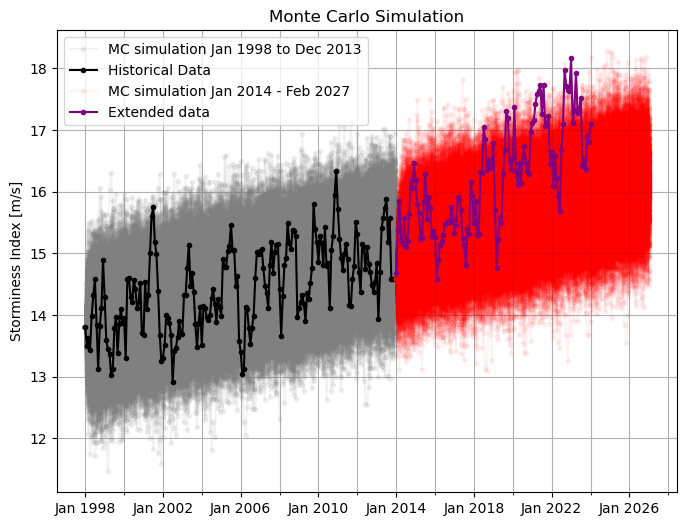

In [32]:
# PLOT 
fig, ax = plt.subplots(figsize=(8, 6))

xticks = np.arange(1998, 2028, 4)
xlabels = [f'Jan {x:1.2f}' for x in xticks]
ax.set_xticks(xticks)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('Jan %g'))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=12))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=2))

ax.set_title('Monte Carlo Simulation')
ax.set_ylabel(r'Storminess Index [m/s]')
ax.grid(which='both')

# Plot each Monte Carlo realization for historical data
ax.plot(years, mc_results[0], '.-', color='gray', alpha=0.1,label='MC simulation Jan 1998 to Dec 2013')
for i in range(1,num_of_simulations):
    ax.plot(years, mc_results[i], '.-', color='gray', alpha=0.1)  

# Plot historical data
ax.plot(years, a_si_short, '.-', color='black', alpha=1, label='Historical Data')

# Plot each Monte Carlo realization for future data
ax.plot(future_years, future_results[0], '.-', color='red', alpha=0.05, label='MC simulation Jan 2014 - Feb 2027') 
for i in range(1,num_of_simulations):
    ax.plot(future_years, future_results[i], '.-', color='red', alpha=0.05)  

    # plot future data
ax.plot(total_years[N:N_total],a_si_long[N:], '.-', color='purple',label='Extended data')

leg = ax.legend()
plt.show()

__3.b)	Would you say your model captured the observations from Jan 2014 to Feb 2024 well? Are these more recent observations a result of internal variability of the system?__  

Our model did not manage to well capture the subsequent observations. This could come from the limitation of modelling the long-term trend as linear as opposed to polynomial/expodential, rather than the effect of potential increasing internal variability. 

__3.c) Could it be that there is a stronger trend than estimated from the Jan 1998 to Dec 2013 data? Fit a quadratic function $x_t=\beta_0+\beta_1*t + \beta_2*t^2+\epsilon_t$ to the long time series from  Jan 1998 to Feb 2024. You can use the function ```np.polyfit()``` for this purpose. Plot the observations together with your new fit and your previous linear estimate.__

In [18]:
# quadratic model

quad_model = lambda x, beta_0, beta_1, beta_2 : beta_0 + x * beta_1 + x**2 * beta_2

months_total = np.arange(N_total)

# linear fit 1

    # perform fit using scipy.optimize.curve_fit
fit_2 = curve_fit(quad_model,months_total,a_si_long)

    # store fit values and corresponding errors
beta0_2, beta1_2, beta2_2 = fit_2[0]
e_beta0_2, e_beta1_2, e_beta2_2 = np.sqrt(np.diag(fit_2[1]))

    # evauate the fitted quadratic model
quad_model_si = quad_model(months_total,beta0_2,beta1_2,beta2_2)
lin_model_si_long = lin_reg(months_total,beta0,beta1)

    # de-trend data
residuals_si_2 = a_si_long - quad_model_si

    # print results
print('beta0:',np.round(beta0_2,2),'+-',np.round(e_beta0_2,2),'m/(s*month)')
print('beta1:',np.round(beta1_2,3),'+-',np.round(e_beta1_2,3),'m/s')
print('beta2:',np.round(beta2_2,6),'+-',np.round(e_beta2_2,6),'m/(s*month^2)')

beta0: 13.95 +- 0.1 m/(s*month)
beta1: 0.001 +- 0.001 m/s
beta2: 3.1e-05 +- 4e-06 m/(s*month^2)


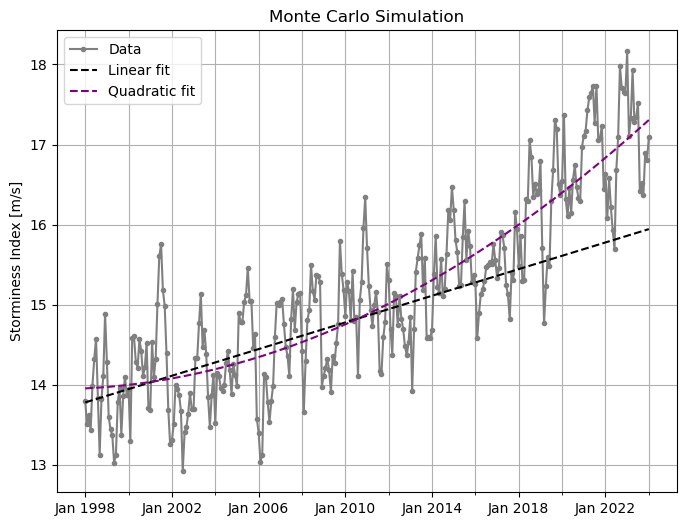

In [19]:
# PLOT 
fig, ax = plt.subplots(figsize=(8, 6))

xticks = np.arange(1998, 2028, 4)
xlabels = [f'Jan {x:1.2f}' for x in xticks]
ax.set_xticks(xticks)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('Jan %g'))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=12))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=2))

ax.set_title('Monte Carlo Simulation')
ax.set_ylabel(r'Storminess Index [m/s]')
ax.grid(which='both')


    # plot data
ax.plot(total_years[:N_total],a_si_long, '.-', color='gray',label='Data')

    # plot linear and quadratic model
ax.plot(total_years[:N_total], lin_model_si_long, '--', color='black',label='Linear fit')
ax.plot(total_years[:N_total], quad_model_si, '--', color='purple',label='Quadratic fit')

ax.legend()
plt.show()

It seems that the polynomial fit is better suited, bringing evidence that there is a stronger than linear trend estimated from the Jan 1998 to Dec 2013 data.

__3.d) Redo the Monte-Carlo simulations from Jan 1998 to Feb 2027 but this time using your quadratic fit and remember to also re-estimate the noise term $\epsilon_t$ based on the newly available extended observational dataset. Again, make sure to use the last observation available when initialising the AR(1) process for future values. Do a quantile plot as in 2.c) but now for the quadratic trend and within the same plot additionally plot the long observations.__

The recursion formula is now 

(5) $x_t = \alpha_2 x_{t-1} + \beta_0(1-\alpha_2) + \beta_1(t-\alpha_2(t-1)) + \beta_2(t^2-\alpha_2(t-1)^2) + w_t$

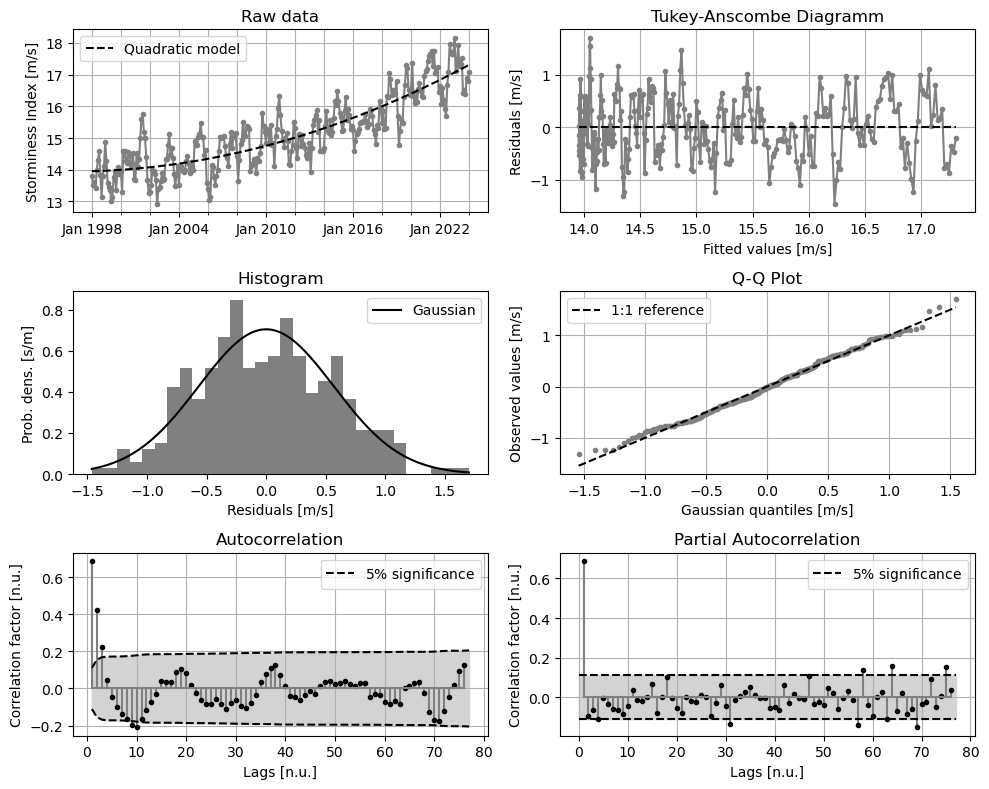

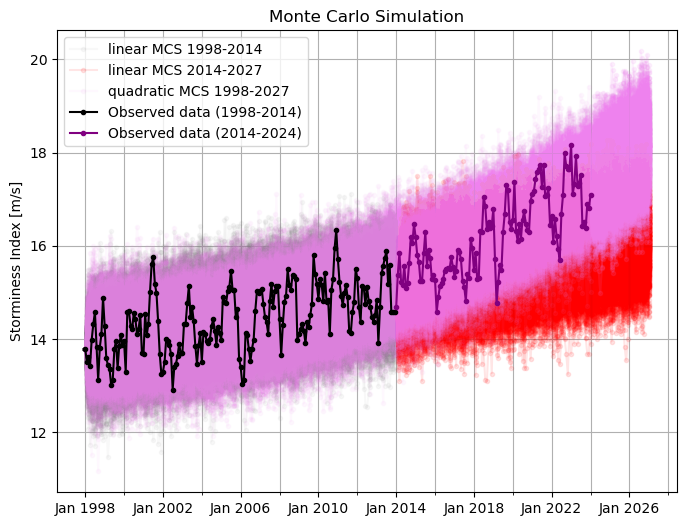

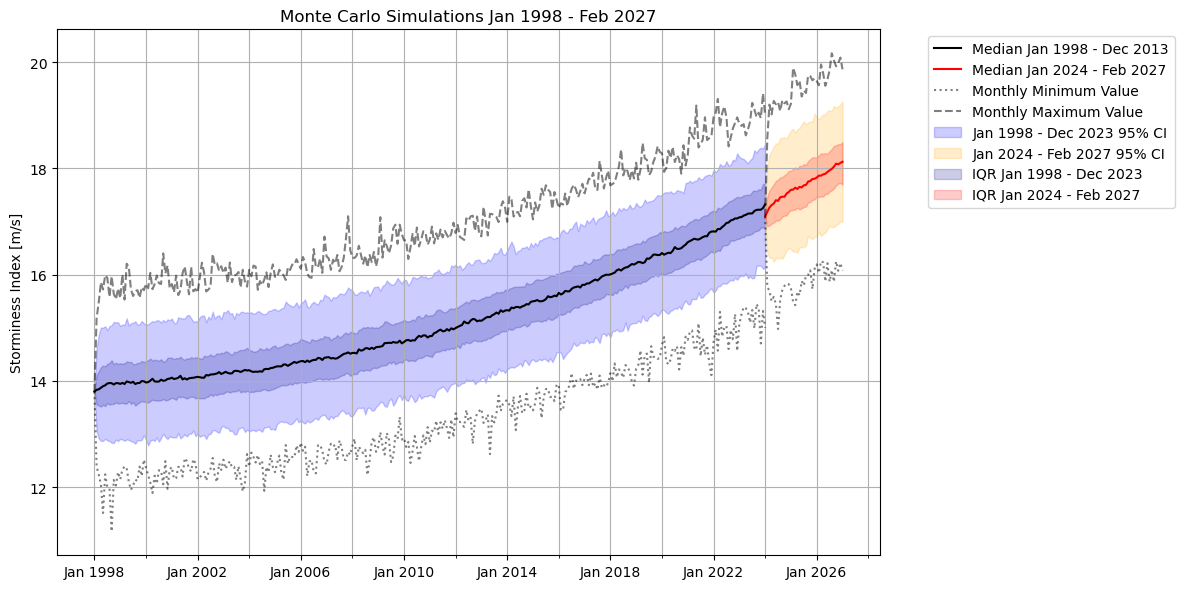

In [33]:
## Plot data, residuals, histogram, Q-Q plot and (partial) autocorrelation

fig, ax = plt.subplots(3,2,figsize=(10,8),gridspec_kw={'height_ratios': [1, 1, 1]})

xticks = np.arange(1998, 2024, 6)
xlabels = [f'Jan {x:1.2f}' for x in xticks]
ax[0,0].set_xticks(xticks)#, labels=xlabels)
ax[0,0].xaxis.set_major_formatter(ticker.FormatStrFormatter('Jan %g'))
ax[0,0].xaxis.set_minor_locator(ticker.MultipleLocator(base=12))
ax[0,0].xaxis.set_minor_locator(ticker.MultipleLocator(base=2))

ax[0,0].set_title('Raw data')
ax[0,0].plot(total_years[:N_total],a_si_long,'.-',color='gray')
ax[0,0].plot(total_years[:N_total], quad_model_si,'--',label='Quadratic model',color='black')
ax[0,0].set_ylabel(r'Storminess Index [m/s]')
ax[0,0].grid(which='both')
ax[0,0].legend()

ax[0,1].set_title('Tukey-Anscombe Diagramm')
ax[0,1].plot(quad_model_si,residuals_si_2,'.-',color='gray')
ax[0,1].plot(quad_model_si,np.zeros(len(quad_model_si)),'--',color='black')
ax[0,1].set_xlabel('Fitted values [m/s]')
ax[0,1].set_ylabel('Residuals [m/s]')
ax[0,1].grid()

a_x_hist_2 = hist(residuals_si_2,30,ax[1,0])

a_x_QQ_2 = QQ_plot(residuals_si_2,ax[1,1])

aut_corr_x_2 = aut_corr(residuals_si_2,ax[2,0])

part_aut_corr_x_2 = part_aut_corr(residuals_si_2,ax[2,1])

    # prevent ugly overlaps of axis labels and titles
plt.tight_layout()


## calculate new model parameter alpha_2 and sigma_2
alpha_2 = part_aut_corr_x_2[1]
w_si_2 = residuals_si_2[1:]-residuals_si_2[:-1]*alpha_2
sigma_2 = np.std(w_si_2)

    # recursion formula
def eq5(x_i,N,Beta0=beta0_2,Beta1=beta1_2,Beta2=beta2_2,Alpha=alpha_2,Sigma=sigma_2): 
    """
    evaluates model (eq. (4)) for N timesteps and initial value x_i and the parameters obtained from above
    """
    a = np.zeros(N)
    a[0] = x_i
    for t in range(1,N):
        a[t] = Alpha*a[t-1]+Beta0*(1-Alpha)+Beta1*(t-Alpha*(t-1))+Beta2*(t**2-Alpha*(t-1)**2)+normal(loc=0,scale=Sigma)
    return a

N_00 = len(a_si_long)

def eq5_future(x_i,N,Beta0=beta0_2,Beta1=beta1_2,Beta2=beta2_2,Alpha=alpha_2,Sigma=sigma_2): 
    """
    evaluates model (eq. (4)) for N timesteps and initial value x_i and the parameters obtained from above
    """
    a = np.zeros(N)
    a[0] = x_i
    for t in range(1,N):
        a[t] = Alpha*a[t-1]+Beta0*(1-Alpha)+Beta1*((t+N_00)-Alpha*((t+N_00)-1))+Beta2*((t+N_00)**2-Alpha*((t+N_00)-1)**2)+normal(loc=0,scale=Sigma)
    return a

## Define parameters: 
    # Initial value for the simulations
x0 = a_si_long[0] 
    # Number of Monte Carlo simulations
num_of_simulations_2 = 1000 
    # Initialize array to store results
mc_results_2 = np.zeros((num_of_simulations_2, N_total)) 

# Perform Monte Carlo simulations
    # Observations
for i in range(num_of_simulations_2):   
    mc_results_2[i] = eq5(x0, N_total)

##Future period Monte Carlo Simulation
# Define parameters for future period
future_years_2 = np.arange(2024, 2027 + 1/12, 1/12)  # Array from Jan 2014 to Feb 2027
future_N_2 = len(future_years_2)  # Length of future period
x0_future_2 = a_si_long[-1] #inital value future period (last observational value) 

future_results_2 = np.zeros((num_of_simulations_2, future_N_2)) # Initialize array to store results for future realizations

for i in range(num_of_simulations_2):                #Monte Carlo simulation for Jan 2014 - Feb 2027
    future_results_2[i] = eq5_future(x0_future_2,future_N_2)

## PLOT
# Plot the simulated data:
fig, ax = plt.subplots(figsize=(8, 6))

xticks = np.arange(1998, 2027, 4)
xlabels = [f'Jan {x:1.2f}' for x in xticks]
ax.set_xticks(xticks)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('Jan %g'))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=12))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=2))

ax.set_title('Monte Carlo Simulation')
ax.set_ylabel(r'Storminess Index [m/s]')
ax.grid(which='both')


    # Plot each Monte Carlo realization for historical data 1998-2014
ax.plot(years, mc_results[0], '.-', color='gray', alpha=0.05,label='linear MCS 1998-2014') 
for i in range(1,num_of_simulations): 
    ax.plot(years, mc_results[i], '.-', color='gray', alpha=0.05) 

    # Plot each Monte Carlo realization for future data 2014-2027
ax.plot(future_years, future_results[0], '.-', color='red', alpha=0.1,label='linear MCS 2014-2027') 
for i in range(1,num_of_simulations):
    ax.plot(future_years, future_results[i], '.-', color='red', alpha=0.1) 

    # Plot each Monte Carlo realization for historical data 1998-2024
ax.plot(total_years[:N_total], mc_results_2[0], '.-', color='violet', alpha=0.05,label='quadratic MCS 1998-2027')
for i in range(1,num_of_simulations_2):
    ax.plot(total_years[:N_total], mc_results_2[i], '.-', color='violet', alpha=0.05) 

    # Plot each Monte Carlo realization for future data 2024-2027
for i in range(num_of_simulations_2):
    ax.plot(future_years_2, future_results_2[i], '.-', color='violet', alpha=0.1)  

    # Plot historical data 1998-2014
ax.plot(total_years[:N],a_si_long[:N], '.-', color='black',label='Observed data (1998-2014)')


    # Plot historical data 2014-2027
ax.plot(total_years[N:N_total],a_si_long[N:], '.-', color='purple',label='Observed data (2014-2024)')

ax.legend()
leg = ax.legend()
plt.show()

# Calculate median for Jan 1998 - Dec 2023
historical_median_2 = np.median(mc_results_2, axis=0)
# Calculate median for Jan 2024 - Feb 2027
future_median_2 = np.median(future_results_2, axis=0)

# Calculate the interquartile range (IQR) for Jan 1998 - Dec 2023
historical_lower_2 = np.percentile(mc_results_2, 25, axis=0)
historical_upper_2 = np.percentile(mc_results_2, 75, axis=0)

# Calculate the interquartile range (IQR) for Jan 2024 - Feb 2027
future_lower_2 = np.percentile(future_results_2, 25, axis=0)
future_upper_2 = np.percentile(future_results_2, 75, axis=0)

# Calculate percentiles for for Jan 1998 - Dec 2023
historical_percentiles_2 = np.percentile(mc_results_2, [2.5, 97.5], axis=0)
historical_lower_2_5_2 = historical_percentiles_2[0]
historical_upper_97_5_2 = historical_percentiles_2[1]

# Calculate percentiles for Jan 2024 - Feb 2027
future_percentiles_2 = np.percentile(future_results_2, [2.5, 97.5], axis=0)
future_lower_2_5_2 = future_percentiles_2[0]
future_upper_97_5_2 = future_percentiles_2[1]

# Calculate minimum and maximum values per month for Jan 1998 - Dec 2023
historical_min_per_month_2 = np.min(mc_results_2, axis=0)
historical_max_per_month_2 = np.max(mc_results_2, axis=0)

# Calculate minimum and maximum values per month for Jan 2024 - Feb 2027
future_min_per_month_2 = np.min(future_results_2, axis=0)
future_max_per_month_2 = np.max(future_results_2, axis=0)

# PLOT
fig, ax = plt.subplots(figsize=(12, 6))

# Set x-axis ticks and labels
xticks = np.arange(1998, 2028, 4)
xlabels = [f'Jan {x:1.2f}' for x in xticks]
ax.set_xticks(xticks)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('Jan %g'))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=12))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=2))

# Set plot title and labels
ax.set_title('Monte Carlo Simulations Jan 1998 - Feb 2027')
ax.set_ylabel(r'Storminess Index [m/s]')
ax.grid(which='both')

# Plot median
ax.plot(total_years[:N_total], historical_median_2, '-', color='black', label='Median Jan 1998 - Dec 2013') 
ax.plot(future_years_2, future_median_2, '-', color='red', label='Median Jan 2024 - Feb 2027')

# Plot percentiles
ax.fill_between(total_years[:N_total], historical_lower_2_5_2, historical_upper_97_5_2, color='blue', alpha=0.2, label='Jan 1998 - Dec 2023 95% CI')
ax.fill_between(future_years_2, future_lower_2_5_2, future_upper_97_5_2, color='orange', alpha=0.2, label='Jan 2024 - Feb 2027 95% CI')

# Plot the area between the interquartile range
ax.fill_between(total_years[:N_total], historical_lower_2, historical_upper_2, color='darkblue', alpha=0.2, label='IQR Jan 1998 - Dec 2023')
ax.fill_between(future_years_2, future_lower_2, future_upper_2, color='red', alpha=0.2, label='IQR Jan 2024 - Feb 2027')

# Plot minimum and maximum values per month for historical data
ax.plot(total_years[:N_total], historical_min_per_month_2, ':', color='black', alpha=0.5, label='Monthly Minimum Value')
ax.plot(total_years[:N_total], historical_max_per_month_2, '--', color='black', alpha=0.5, label='Monthly Maximum Value')

# Plot minimum and maximum values per month for future data
ax.plot(future_years_2, future_min_per_month_2, ':', color='black', alpha=0.5)
ax.plot(future_years_2, future_max_per_month_2, '--', color='black', alpha=0.5)


ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax.grid(True)

plt.tight_layout()  # Adjust layout to prevent clipping of legend
plt.show()

__3.e)	Look at the end of your forecast period. Do you think that the observations will be within the range of your predictions in 2027? Can you extrapolate your forecast into the far future and make realistic predictions of the storminess in e.g. 100 or 200 years? Answer in 2-3 Sentences.__

Our previous linear model was still good enough in predicting the data up to 3-5 years after its training data, which would go to support that our new polynomial trend should be sufficient in predicting future observations sufficiently till 2027. However, given that our model had to change after 10 years, and that partial autocorrelation seems to be increasing with the number of lags, it would not be very realistic to make realistic predictions far in the future. Our model is very data-driven and does not incorportate any physical data and logic, therefore it could suffer from overfitting/being too simplistic, and many other hard to model factors, such as human interference in the form of increased emissions or emission mitigation/adaptation could play a larger role in determining the long-term trend.

## 4. Uncertainty of impact and mitigation costs
### Impact costs

__4.a) Given the information above, figure out the parameters and expression of the impact costs, including some sort of exponential function of SI. There is no strict right or wrong function. Generate a function that looks meaningful to you and explain why. Plot the impact costs as a function of SI ranging from $15 m s^{-1}$ to $24 m s^{-1}$.__


Treshold value: the house remains fully protected until SI = 16 m/s

Maximum Damge: if SI > 22 m/s the house suffers maximum storm damage, amounting to $ 50'000

Repair frequency: damages are repaired every month

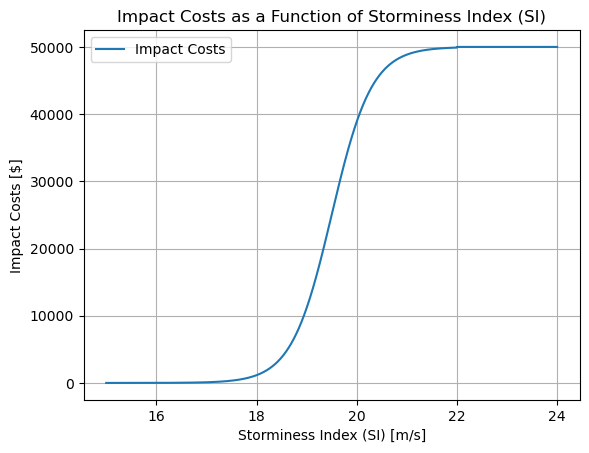

In [21]:
# Define the exponential function for impact costs

"""
A = 1. # growth rate

def impact_costs(SI):
    if SI <= 16:
        return 0
    elif SI <= 22:
        return 50000 * (np.exp(A * (SI - 16)) - 1) / (np.exp(A * (22 - 16)) - 1)  # Exponential increase between SI = 16 m/s and SI = 22 m/s
    else:
        return 50000

def Impact_costs(SI_array):
    impact_costs_array = np.zeros_like(SI_array)  # Initialize an array to store impact costs
    
    # Loop through each element in the SI_array and calculate the impact cost
    for i, SI in enumerate(SI_array):
        impact_costs_array[i] = impact_costs(SI)
    
    return impact_costs_array
"""

    # The sigmoid function has two degrees of freedom 
S_1 = 19.5
S_2 = .4

def impact_costs(SI):
    return 50000*(1-1/(1+np.exp((SI-S_1)/S_2)))

def Impact_costs(SI):
    l = len(SI)
    res = np.zeros(l)
    for i in range(l):
        # Here the case distinction is only made, because it was explicitly requested in the task ... its an artefact and in principle not necessary
        if SI[i] >= 16:
            res[i] = impact_costs(SI[i])
        if SI[i] >= 22:
            res[i] = 50000
    return res

SI_values = np.linspace(15, 24, 10000)
costs = Impact_costs(SI_values)

# PLOT
plt.plot(SI_values, costs, label='Impact Costs')
plt.title('Impact Costs as a Function of Storminess Index (SI)')
plt.xlabel('Storminess Index (SI) [m/s]')
plt.ylabel('Impact Costs [$]')
plt.grid(True)
plt.legend()
plt.show()



We have chosen a sigmoid function for the damace function because it is commonly used for this purpose, furthermore it is smooth and with the two parameters ```S_1``` and ```S_2``` its steepnes, i.e. abruptnes of the cost increas can be controlled adequately.

To choose an appropriate damage function, for example empirical data about the relation of costs and SI could be used to fit the two parameters ```S_1``` and ```S_2```. It is also possible that empirical data reveals that the sigmoid is inappropriate and another function has to be taken as damage function. 

__4.b)	Considering the distribution of the March 2024 forecasts, how high are the impact costs in terms of the median, 2.5% and 97.5% quantile?__

In [22]:
impact_cost_202403 = Impact_costs(future_results_2[:,2])

print(' 2.5 percent quantile: %.2f $' %np.percentile(impact_cost_202403,  2.5))
print('50.0 percent quantile: %.2f $' %np.percentile(impact_cost_202403, 50.0))
print('97.5 percent quantile: %.2f $' %np.percentile(impact_cost_202403, 97.5))
                      

 2.5 percent quantile: 15.03 $
50.0 percent quantile: 179.07 $
97.5 percent quantile: 1978.59 $


__4.c)	Plot the temporal evolution of mean, median, interquartile range, 2.5 and 97.5 percentile, and the minimum and maximum impact cost for the whole duration of your forecast (i.e., the 36 months from Mar 2024 – Feb 2027). Additionally, have a look at the respective (mean, median, ...) cumulative costs as a function of forecast lead-time until 2027. Make sure to apply the different functions (```pd.DataFrame.quantile(.)``` / ```your_cost_function(.)``` / ```pd.DataFrame.cumsum(.)```) in a sensible order.__

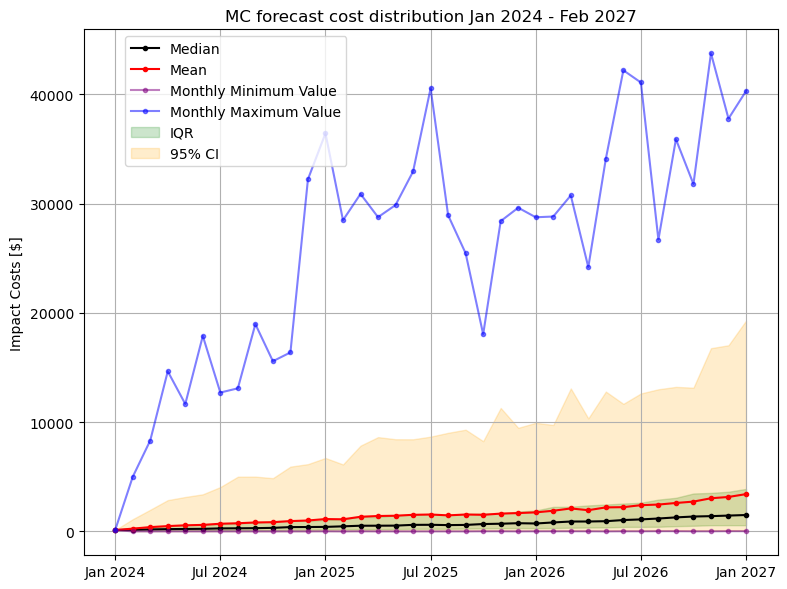

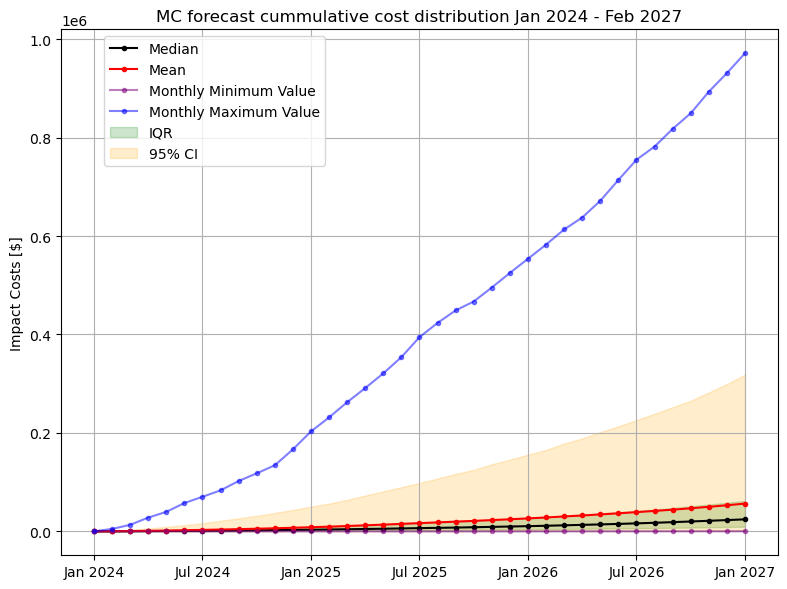

In [23]:
# Initialize empty lists to store impact costs for each month
impact_costs_median = []
impact_costs_mean = []
impact_costs_iqr_lower = []
impact_costs_iqr_upper = []
impact_costs_per_lower = []
impact_costs_per_upper = []
impact_costs_min_per_month = []
impact_costs_max_per_month = []


# Iterate over each month's values
for month_values in np.transpose(future_results_2):  # Transpose future_results_2 to iterate over months 

    # Calculate impact costs median, mean, IQR, percentiles, min and max for the current month and append to respective lists
    impact_costs_month_values = Impact_costs(month_values)
    impact_costs_median.append( np.median(impact_costs_month_values) )
    impact_costs_mean.append( np.mean(impact_costs_month_values) )
    impact_costs_iqr_lower.append( np.percentile(impact_costs_month_values, 25) )
    impact_costs_iqr_upper.append( np.percentile(impact_costs_month_values, 75) )
    impact_costs_per_lower.append( np.percentile(impact_costs_month_values, 2.5) )
    impact_costs_per_upper.append( np.percentile(impact_costs_month_values, 97.5) )
    impact_costs_min_per_month.append( np.min(impact_costs_month_values) )
    impact_costs_max_per_month.append( np.max(impact_costs_month_values) )
    
    # calculate the cummulative costs
def cummulation(array):
    cum_array = np.zeros(len(array))
    cum_array[0] = array[0]
    for i in range(1,len(array)):
        cum_array[i] = array[i] + cum_array[i-1]
    return cum_array

cum_impact_costs_median = cummulation(impact_costs_median)
cum_impact_costs_mean = cummulation(impact_costs_mean)
cum_impact_costs_iqr_lower = cummulation(impact_costs_iqr_lower)
cum_impact_costs_iqr_upper = cummulation(impact_costs_iqr_upper)
cum_impact_costs_per_lower = cummulation(impact_costs_per_lower)
cum_impact_costs_per_upper = cummulation(impact_costs_per_upper)
cum_impact_costs_min_per_month = cummulation(impact_costs_min_per_month)
cum_impact_costs_max_per_month = cummulation(impact_costs_max_per_month)

    # plott costs
fig, ax = plt.subplots(figsize=(8, 6))

    # Set x-axis ticks and labels
xticks = np.arange(2024, 2028, 0.5)
xlabels = []
for i in range(len(xticks)):
    if xticks[i] % 1 == 0:
        xlabels.append(f'Jan {int(xticks[i])}')
    if xticks[i] % 1 != 0:
        xlabels.append(f'Jul {int(xticks[i-1])}')
ax.set_xticks(xticks)
ax.xaxis.set_major_locator(ticker.FixedLocator(xticks))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(xlabels))

# Set plot title and labels
ax.set_title('MC forecast cost distribution Jan 2024 - Feb 2027')
ax.set_ylabel(r'Impact Costs [$]')
ax.grid(which='both')

ax.plot(future_years_2,impact_costs_median,'.-',color='black',label='Median')
ax.plot(future_years_2,impact_costs_mean,'.-',color='red',label='Mean')
ax.fill_between(future_years_2, impact_costs_iqr_lower, impact_costs_iqr_upper, color='green', alpha=0.2, label='IQR')
ax.fill_between(future_years_2, impact_costs_per_lower, impact_costs_per_upper, color='orange', alpha=0.2, label='95% CI')
ax.plot(future_years_2, impact_costs_min_per_month, '.-', color='purple', alpha=0.5,label='Monthly Minimum Value')
ax.plot(future_years_2, impact_costs_max_per_month, '.-', color='blue', alpha=0.5,label='Monthly Maximum Value')


ax.legend(bbox_to_anchor=(0.05, 1), loc='upper left')
ax.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of legend
plt.show()

    # plot cummulative costs
fig, ax = plt.subplots(figsize=(8, 6))

# Set x-axis ticks and labels
xticks = np.arange(2024, 2028, 0.5)
xlabels = []
for i in range(len(xticks)):
    if xticks[i] % 1 == 0:
        xlabels.append(f'Jan {int(xticks[i])}')
    if xticks[i] % 1 != 0:
        xlabels.append(f'Jul {int(xticks[i-1])}')
ax.set_xticks(xticks)
ax.xaxis.set_major_locator(ticker.FixedLocator(xticks))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(xlabels))

# Set plot title and labels
ax.set_title('MC forecast cummulative cost distribution Jan 2024 - Feb 2027')
ax.set_ylabel(r'Impact Costs [$]')
ax.grid(which='both')

ax.plot(future_years_2,cum_impact_costs_median,'.-',color='black',label='Median')
ax.plot(future_years_2,cum_impact_costs_mean,'.-',color='red',label='Mean')
ax.fill_between(future_years_2, cum_impact_costs_iqr_lower, cum_impact_costs_iqr_upper, color='green', alpha=0.2, label='IQR')
ax.fill_between(future_years_2, cum_impact_costs_per_lower, cum_impact_costs_per_upper, color='orange', alpha=0.2, label='95% CI')
ax.plot(future_years_2, cum_impact_costs_min_per_month, '.-', color='purple', alpha=0.5,label='Monthly Minimum Value')
ax.plot(future_years_2, cum_impact_costs_max_per_month, '.-', color='blue', alpha=0.5,label='Monthly Maximum Value')


ax.legend(bbox_to_anchor=(0.05, 1), loc='upper left')
ax.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of legend
plt.show()




__4.d)	Discuss if you would invest in either A, B or none of the options for the time horizon of your forecast (i.e., the 36 months from Mar 2024 – Feb 2027). For this purpose, plot the damage functions with the respective measures A and B in place (as in 4.a), and examine the temporal evolution of the _mean_ expected (cumulative) damage (as in 4.c).__

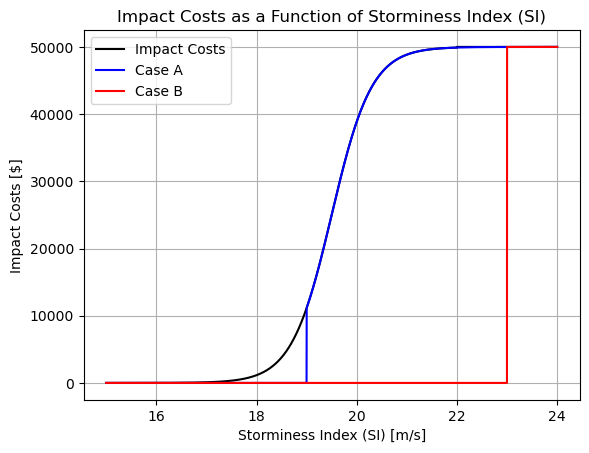

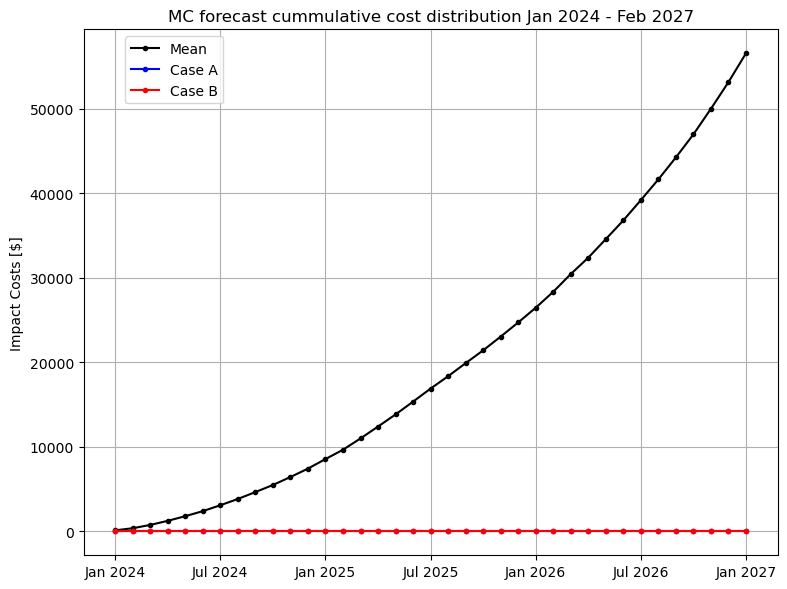

In [24]:
# impact damage function for case A

def Impact_costs_A(SI):
    l = len(SI)
    res = np.zeros(l)
    for i in range(l):
        if SI[i] >= 19:
            res[i] = impact_costs(SI[i])
    return res

costs_A = Impact_costs_A(SI_values)

# impact damage function for case B

def Impact_costs_B(SI):
    l = len(SI)
    res = np.zeros(l)
    for i in range(l):
        if SI[i] >= 23:
            res[i] = impact_costs(SI[i])
    return res

costs_B = Impact_costs_B(SI_values)


# PLOT
plt.plot(SI_values, costs,color='black', label='Impact Costs')
plt.plot(SI_values, costs_A,color='blue', label='Case A')
plt.plot(SI_values, costs_B,color='red', label='Case B')
plt.title('Impact Costs as a Function of Storminess Index (SI)')
plt.xlabel('Storminess Index (SI) [m/s]')
plt.ylabel('Impact Costs [$]')
plt.grid(True)
plt.legend()
plt.show()

    # calculate cummulative mean error
impact_costs_mean_A = []
impact_costs_mean_B = []

for month_values in np.transpose(future_results_2):
    impact_costs_month_values_A = Impact_costs_A(month_values)
    impact_costs_month_values_B = Impact_costs_B(month_values)
    
    impact_costs_mean_A.append( np.median(impact_costs_month_values_A) )
    impact_costs_mean_B.append( np.median(impact_costs_month_values_B) )

cum_impact_costs_mean_A = cummulation(impact_costs_mean_A)
cum_impact_costs_mean_B = cummulation(impact_costs_mean_B)

    # plot cummulative costs
fig, ax = plt.subplots(figsize=(8, 6))

# Set x-axis ticks and labels
xticks = np.arange(2024, 2028, 0.5)
xlabels = []
for i in range(len(xticks)):
    if xticks[i] % 1 == 0:
        xlabels.append(f'Jan {int(xticks[i])}')
    if xticks[i] % 1 != 0:
        xlabels.append(f'Jul {int(xticks[i-1])}')
ax.set_xticks(xticks)
ax.xaxis.set_major_locator(ticker.FixedLocator(xticks))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(xlabels))

# Set plot title and labels
ax.set_title('MC forecast cummulative cost distribution Jan 2024 - Feb 2027')
ax.set_ylabel(r'Impact Costs [$]')
ax.grid(which='both')


ax.plot(future_years_2,cum_impact_costs_mean,'.-',color='black',label='Mean')
ax.plot(future_years_2,cum_impact_costs_mean_A,'.-',color='blue',label='Case A')
ax.plot(future_years_2,cum_impact_costs_mean_B,'.-',color='red',label='Case B')


ax.legend(bbox_to_anchor=(0.05, 1), loc='upper left')
ax.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of legend
plt.show()

From the last plot it becomes clear that both measures prevent damagee costs completely at least until 2027. The cost for option B are higher than the cummulative storm damage costs up to the year 2027, so option B is not worth (here inflation is neglected – due to inflation, damages in the future become less expensive, and therefore the cummulative cost curve would have to be corrected downwards, which might change the argument). However the cost for option A is less than the damage costs, so it is worth to invest in option A.

It is important to mention, that the results in the last few plots crucially depend on the choice of the damage function and in the case of a sigmoid of the two parameters ```S_1``` and ```S_2```. Even slight changes of these parameters can have a significant effect on the cummulative cost curve and would change the the predictions drastically!

__4.e)	Assuming you would invest for the next 10 years; qualitatively discuss which option makes most sense. Which uncertainties do you need to take into consideration for your decision?__

The answer depends amongst other thing on the interest rate. If the interest rate is high enough to compensate of storm damage costs and protection measure costs, than saving is better than investing in protection from a monetary point of view. However, if one also takes ecological aspects into account, for example that protection is probably more sustainable than repairing, then investing into protection measures might be the better option.

__4.f)	Based on your storminess forecast, how would you protect your house in the long term in order to minimize costs? Argument how an interest rate of 5 % would affect your decision in 4.d) and 4.e).__

If the assumed quadradic term is still valid also for the next decade, then a drastic and polynomial increase in storm damage has to be expected at higher rate than at the interest rate of 5% and thus investing in measure B or even in better protection is recommended from a financial standpoint. 